# Initial setup

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import pickle

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load saved keys from API key file
keys = pickle.load(open('api_key.p', 'rb'))
auth = tw.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tw.API(auth, wait_on_rate_limit=True)

# Get trending topics

In [14]:
# See available regions
# api.trends_available() # worldwide has woeid (Where On Earth IDentifier) of 1; US of 23424977

# Get worldwide trending topics
trends1 = api.trends_place(23424977) # 23424977 is the US

# Extract topic name and number of tweets for each
trends = [(trend['name'], trend['tweet_volume']) for trend in trends1[0]['trends']]

# Create pandas df
trends_df = pd.DataFrame(trends, columns=['Topic', 'Count'])
trends_df.head(10)

,Topic,Count
0,Jersey City,69183.0
1,#BROCKHAMPTON,24373.0
2,Mac Pro,15685.0
3,Barr,552681.0
4,#ripnickcannon,63116.0
5,#ImpeachAndConvictTrump,33755.0
6,#HumanRightsDay,201591.0
7,Lauren London,18961.0
8,#TuesdayThoughts,74824.0
9,USMCA,171813.0


# Use API to download tweets

In [7]:
# Download tweets based on a specific trending topic using API (slow)

# Specify topic of interest
topic = trends_df.Topic[0] # Jersey City
search_term = topic + ' -filter:retweets'

# Get tweets
tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2019-12-09').items(10) # Only 10 for now

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]

["⌚️ HALF TIME'\n\n⚡️ LYON 🆚 RB LEIPZIG\n#⃣ #OLRBL   0-2\n\n⚡️ BENFICA 🆚 ZÉNITH \n#⃣ #SLBZSP 0-0\n\n⚡️ BORUSSIA DORTMUND 🆚 S… https://t.co/zGA6cV5bdX",
 '⏰ HALF-TIME | #UCL ⏰\n\n#BVBSLA 1-1\n#InterBarça 1-1\n#OLRBL 0-2\n#SLBZenit 0-0\n#AJAVAL 0-1\n#CHELOSC 2-0\n\nThe best life… https://t.co/ECOTEpm1xq',
 'Big second half needed.\n\n#UCL #OLRBL https://t.co/TZCyglKKqh',
 "⌚️ LIVE 45+4'\n\n⚡️ LYON 🆚 RB LEIPZIG\n#⃣ #OLRBL   0-2\n\n⚡️ BENFICA 🆚 ZÉNITH \n#⃣ #SLBZSP 0-0\n\n⚡️ BORUSSIA DORTMUND 🆚 S… https://t.co/tWSEMrwkWZ",
 'HT: Lyon 0-2 Leipzig\n\nNot a massive amount between the sides, but 2 silly penalties have the visitors on easy stree… https://t.co/0tRTFVHU4u']

# GetOldTweets to download tweets
Based on: https://github.com/fajarmf10/GetOldTweets-python and https://github.com/Jefferson-Henrique/GetOldTweets-python/issues/52#issuecomment-276932885

Steps taken:
- git clone https://github.com/Jefferson-Henrique/GetOldTweets-python
- cd GetOldTweets-python
- mv got3 ~/anaconda3/lib/python3.7/site-packages
- pip install pyquery

In [3]:
# Get old tweets
import got3

In [35]:
# Download tweets using GetOldTweets instead of API
# Specify trending topic of interest
topic = trends_df.Topic[0] # Jersey City
numTweets = 100 # How many tweets to scrape (about 20 per s)
tweetCriteria = got3.manager.TweetCriteria().setQuerySearch(topic).setLang('english').setSince('2019-12-10').setUntil('2019-12-11').setMaxTweets(numTweets)

# Get tweets
tweets = got3.manager.TweetManager.getTweets(tweetCriteria)

# Create pandas df
all_tweets_df = pd.DataFrame([], columns=['ID', 'Link', 'Username', 'Text',
                                          'Date', 'Retweets', 'Favorites',
                                          'Mentions', 'Hashtags', 'Geo',
                                          'URLs', 'Author_ID'])
for i in range(numTweets):
    all_tweets_df.loc[i] = [tweets[i].id, tweets[i].permalink, tweets[i].username, tweets[i].text,
                            tweets[i].date, tweets[i].retweets, tweets[i].favorites,
                            tweets[i].mentions, tweets[i].hashtags, tweets[i].geo,
                            tweets[i].urls, tweets[i].author_id]
all_tweets_df.head(20)

,ID,Link,Username,Text,Date,Retweets,Favorites,Mentions,Hashtags,Geo,URLs,Author_ID
0,1204507516882821121,https://twitter.com/tearinmyrose/status/120450...,,bro i do not want to HEAR IT. We are jersey ci...,2019-12-10 16:05:45,0,0,,,,,1094654627470024705
1,1204507515960123392,https://twitter.com/PatriotNews/status/1204507...,,"Police officer dies in Jersey City shooting, 2...",2019-12-10 16:05:45,0,0,,,,https://trib.al/k4Uu1HP,14323759
2,1204507515872063488,https://twitter.com/fakessh/status/12045075158...,,"Jersey City police officer killed, 2 others sh...",2019-12-10 16:05:45,0,0,,,,https://www.foxnews.com/us/new-jersey-bodega-a...,163644726
3,1204507514232029185,https://twitter.com/breland_joseph/status/1204...,,#BreakingNews @CBSEveningNews @W7VOA @fox5ny @...,2019-12-10 16:05:44,0,0,@CBSEveningNews @W7VOA @fox5ny @fox5dc @FOX5At...,#BreakingNews #JerseyCity,,https://twitter.com/Jerusalem_Post/status/1204...,1180510248848777216
4,1204507513812660225,https://twitter.com/washingtonpost/status/1204...,,"Shootout in Jersey City leaves several dead, i...",2019-12-10 16:05:44,0,0,,,,https://www.washingtonpost.com/nation/2019/12/...,2467791
5,1204507513808412672,https://twitter.com/JerseyCity1982/status/1204...,,It’s 2019... I’ve been hearing this same discu...,2019-12-10 16:05:44,0,0,,,,,1172796879618420736
6,1204507512466288641,https://twitter.com/GraysonsTables/status/1204...,,When will this end?! There was a shooting near...,2019-12-10 16:05:44,0,0,,,,,1102350095620677633
7,1204507512331997185,https://twitter.com/Yretciva/status/1204507512...,,"For @shannonrwatts ""Can someone let her know t...",2019-12-10 16:05:44,0,0,@shannonrwatts,,,,2998656290
8,1204507508435374080,https://twitter.com/gm_noticias/status/1204507...,,#JerseyCity VIDEO: La condición de los tres he...,2019-12-10 16:05:43,0,0,,#JerseyCity,,https://cutt.ly/7e5uJe0,1001935425580265472
9,1204507507135262726,https://twitter.com/walicolt2020/status/120450...,,#Breaking Jersey City Live #Updates https:// y...,2019-12-10 16:05:43,0,0,,#Breaking #Updates,,https://youtu.be/nyLZX_5jGZo,1016776383811506176


# Basic EDA of 'Text'

In [36]:
# Function to standardize text (make lowercase and remove URLs, mentions, and non-alphanumeric characters)
def standardize_text(df):
    df = df.str.lower() # Make everything lowercase
    df = df.str.replace(r"http\S+", "") # Remove URLs
    df = df.str.replace(r"http", "") # Remove "http"s
    df = df.str.replace(r"pic.twitter.com\S+", "") # Remove "pic.twitter.com"s
    df = df.str.replace(r"@\S+", "") # Remove mentions
    df = df.str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") # Remove any non-alphanumeric chars
    df = df.str.replace(r"@", "at") # Replace "@" with "at"
    return df

# Clean up 'Text'
clean_tweets = standardize_text(all_tweets_df['Text'])
clean_tweets[:5]

0    bro i do not want to hear it  we are jersey ci...
1    police officer dies in jersey city shooting, 2...
2    jersey city police officer killed, 2 others sh...
3     breakingnews            five people found dea...
4    shootout in jersey city leaves several dead, i...
Name: Text, dtype: object

In [37]:
# Create a list of lists containing words for each tweet
words_in_tweet = [tweet.split() for tweet in clean_tweets]

# Set stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Add query words to stopwords
stop_words.extend(topic.lower().split(' '))

# Remove stopwords
tweets_nsw = [[word for word in tweet_words if word not in stop_words]
              for tweet_words in words_in_tweet]

# Determine all words used
all_words_nsw = list(itertools.chain(*tweets_nsw))

# Create counter of words in tweets
counts_nsw = collections.Counter(all_words_nsw)

# Create dataframe for counter
clean_tweets_df = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
clean_tweets_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amywen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,words,count
0,police,44
1,officer,35
2,shooting,34
3,com,29
4,jerseycity,26


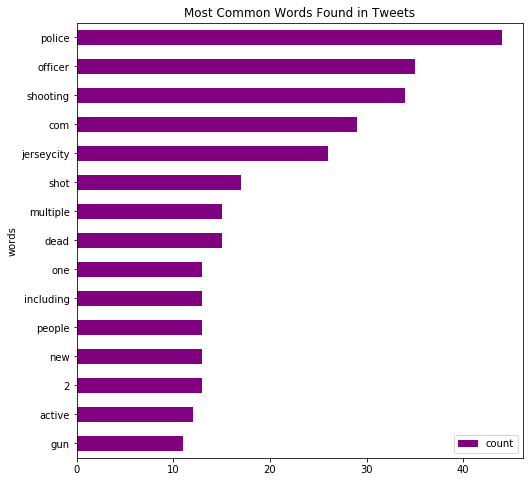

In [38]:
# Plot horizontal bar graph of most frequent words
fig, ax = plt.subplots(figsize=(8, 8))

clean_tweets_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Common Words Found in Tweets")

plt.show()